In [1]:
#Import the packages
import scanpy as sc 
import numpy as np 
import pandas as pd 
import anndata

Preprocessing

In [2]:
adata = sc.read_10x_mtx(
    "C:/Users/melod/Desktop/RongRong/Dry/Progression/filtered/filtered_feature_bc_matrix")

In [3]:
sc.pp.filter_cells(adata , min_genes = 200) 
sc.pp.filter_genes(adata , min_cells = 3)  

In [4]:
#Get the mitochondria genes
adata.var['mt'] = adata.var_names.str.startswith('mt-') 

In [5]:
sc.pp.calculate_qc_metrics(adata , qc_vars=['mt'] , percent_top=None , log1p=False , inplace=True)

In [6]:
#Subset the cells with counts between 2%-98%
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values , .98)
lower_lim = np.quantile(adata.obs.n_genes_by_counts.values , .02)
print(f'{lower_lim} to {upper_lim}')

454.4 to 2726.3599999999997


In [7]:
#Subset the cells as the condition we set.
adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
adata = adata[adata.obs.pct_counts_mt < 20, :]

In [8]:
#Normalization
sc.pp.normalize_total(adata ,target_sum = 1e4)
sc.pp.log1p(adata)

c:\Users\melod\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [9]:
#Find out highly variable genes, and save the raw data.
sc.pp.highly_variable_genes(adata)
adata.raw = adata

In [10]:
#Regress out the counts and mitochondria percentage before scale data, and do the pca.
adata = adata[: , adata.var.highly_variable]
sc.pp.regress_out(adata , ["total_counts" , "pct_counts_mt"])
sc.pp.scale(adata , max_value=10)
sc.tl.pca(adata , svd_solver="arpack")

c:\Users\melod\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


c:\Users\melod\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\melod\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\melod\AppData\Local\Programs\Python\Python3

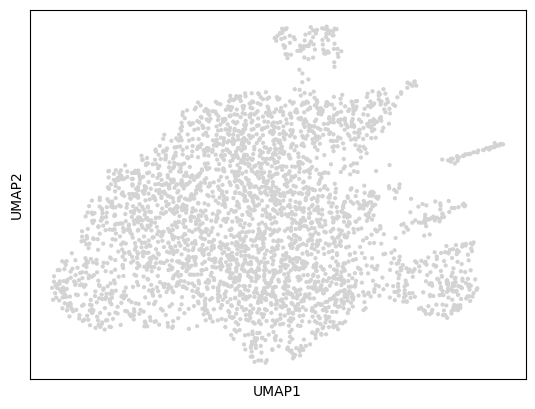

c:\Users\melod\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


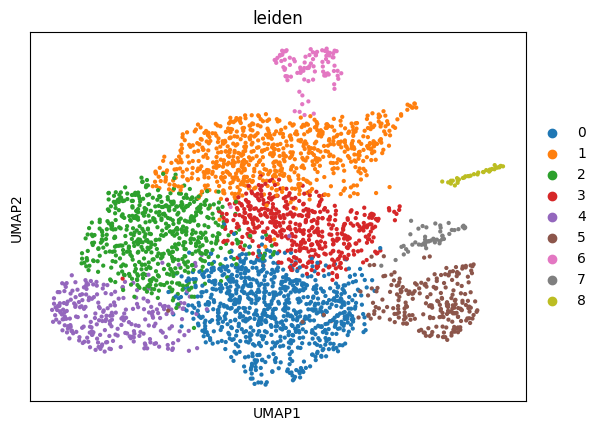

In [11]:
#Find neighbors and cluster the cells.
sc.pp.neighbors(adata , n_neighbors=10 , n_pcs = 20)
sc.tl.umap(adata)
sc.pl.umap(adata)
sc.tl.leiden(adata , resolution = 0.5)
sc.pl.umap(adata , color=["leiden"])

In [14]:
#Save h5ad files
adata.write_h5ad('C:/Users/melod/Desktop/RongRong/Dry/scRNA-seq_Tutorial/Progression.h5ad')

Optional

In [ ]:
#Create a function for preprocessing
def pp(path):
    adata = sc.read_10x_mtx(path)
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
    adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
    adata = adata[adata.obs.pct_counts_mt < 20]
    sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
    sc.pp.log1p(adata) #change to log counts
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values
    adata.raw = adata #save raw data before processing values and further filtering
    adata = adata[:, adata.var.highly_variable] #filter highly variable
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
    sc.pp.scale(adata, max_value=10) #scale each gene to unit variance
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
    sc.tl.leiden(adata, resolution = 0.25)
    sc.tl.umap(adata)
    return adata

In [ ]:
#Preprocessing
adata = pp("C:/Users/melod/Desktop/RongRong/Dry/Progression/filtered/filtered_feature_bc_matrix")